# Introduction

This notebook aims to solve the Image Classification problem using Convolutional Neural Networks given by the [Startup-Crafters](https://www.linkedin.com/company/startup-crafters/) as a part of Skill Assessment Test for Machine Learning Engineer Role. The datasets has following 6 classes:
- Bicycle
- Boat
- Cat
- Motorbike
- People
- Table



## Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Modules

In [22]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.layers import Conv2D, Dropout, MaxPooling2D, Input, Flatten, BatchNormalization, Dense
from keras.models import Model, load_model
from sklearn.metrics import accuracy_score, classification_report

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Loading Datasets

### Train and Validation Data

In [4]:
train_dir = '/content/drive/MyDrive/Study/Startup-Crafters-Test/Datasets/Dataset/Training'
val_dir = '/content/drive/MyDrive/Study/Startup-Crafters-Test/Datasets/Dataset/Validation'

classes = ['Bicycle', 'Boat', 'Cat', 'Motorbike', 'People', 'Table']

def prepare_data(directory, categories=None):
    data = []
    labels = []
    for category in categories:
        class_path = os.path.join(directory, category)
        for img in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img)
            image = load_img(img_path, target_size=(224, 224, 3))
            image = img_to_array(image)
            image /= 255.
            data.append(image)
            labels.append(category)
    return data, labels

print('Loading Train sets....')
train_data, train_labels = prepare_data(train_dir, classes)
print('\nLoading Validation sets....')
val_data, val_labels = prepare_data(val_dir, classes)

Loading Train sets....


100%|██████████| 240/240 [00:50<00:00,  4.71it/s]



Loading Validation sets....


100%|██████████| 80/80 [00:23<00:00,  3.43it/s]


### Test Dataset

In [5]:
test_df = pd.read_csv('/content/drive/MyDrive/Study/Startup-Crafters-Test/Datasets/AI_Basic_Test/test_set.csv')
test_df['Image_Path'] = test_df['Image_Path'].str.replace('Testing/', '')
image_paths = test_df['Image_Path'].tolist()
test_dir = '/content/drive/MyDrive/Study/Startup-Crafters-Test/Datasets/Dataset/Testing'
data = []
print('Loading Test Sets...')
for img in tqdm(image_paths):
    path = os.path.join(test_dir, img)
    image = load_img(path, target_size=(224, 224, 3))
    image = img_to_array(image)
    image /= 255.
    data.append(image)

Loading Test Sets...


100%|██████████| 480/480 [02:03<00:00,  3.90it/s]


## Data Visualization

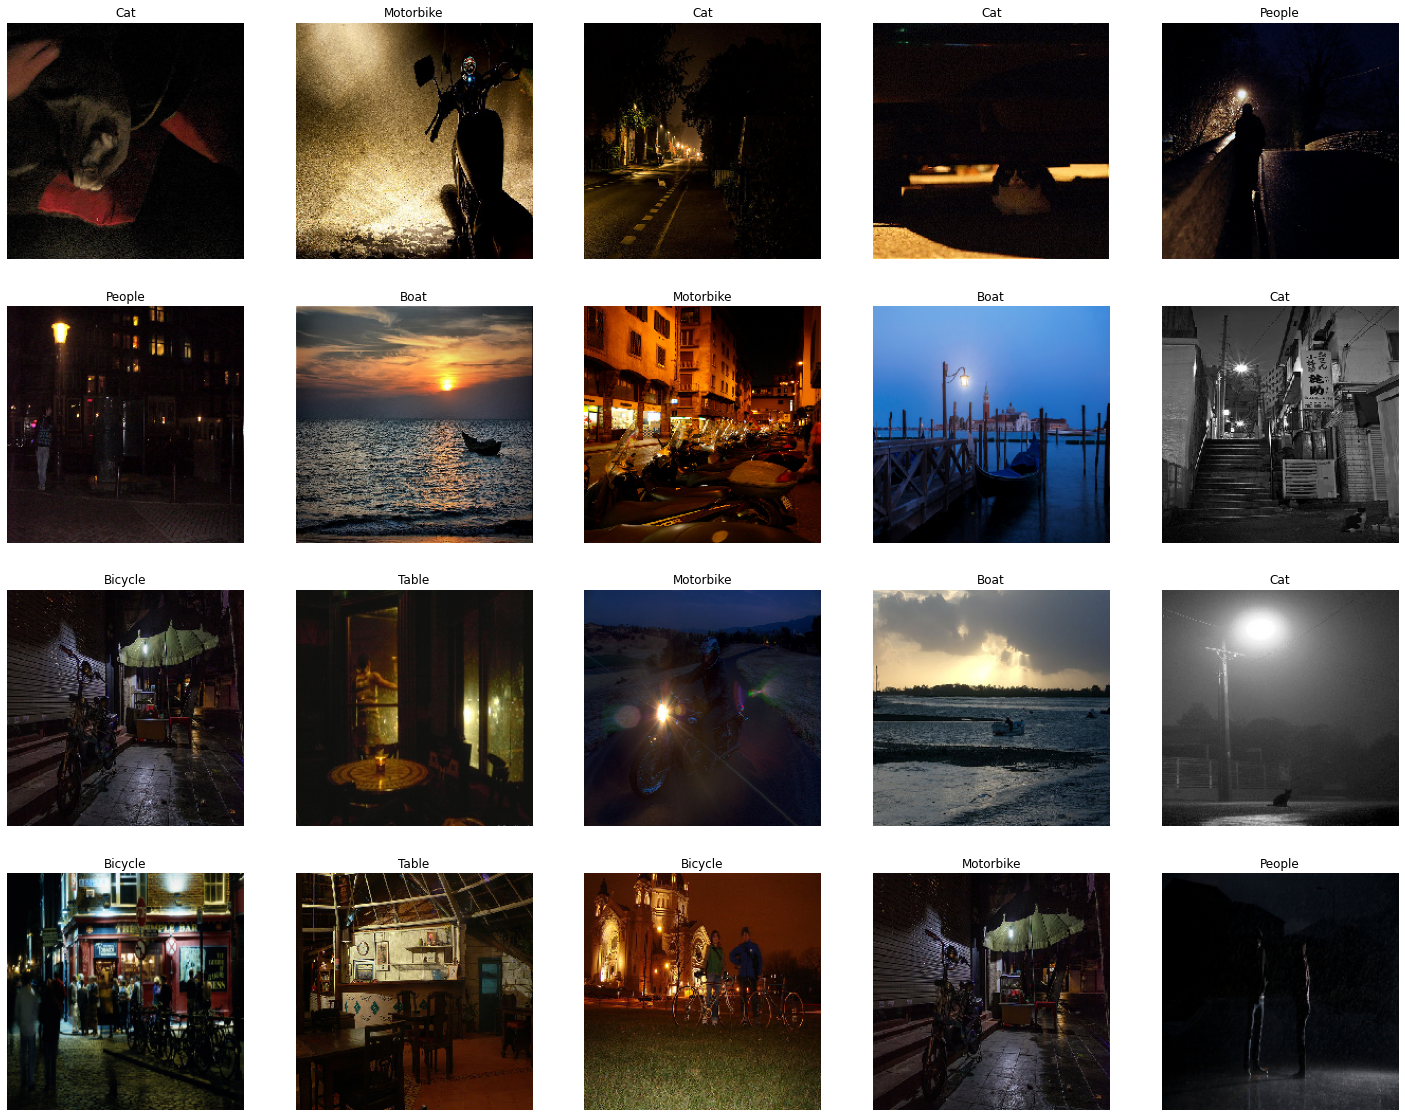

In [6]:
def plot_images():
    n_images = 20
    n_rows, n_cols = 4, 5
    temp_index = [random.randint(0, len(train_data)) for _ in range(n_images)]
    plt.figure(figsize=(n_cols * 5, n_rows * 5))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(train_data[temp_index[index]])
            plt.axis('off')
            plt.title(train_labels[temp_index[index]], fontsize=12)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    plt.show()

plot_images()

## Data Preprocessing

In [7]:
def convert_labels(labels, classes):
    '''
    Convert class lables from string to int.
    Bicycle --> 0, Boat --> 1, ...., Table --> 5
    '''
    return [classes.index(label) for label in labels]

y_train = convert_labels(train_labels, classes)
y_val = convert_labels(val_labels, classes)

In [8]:
X_train, y_train = np.array(train_data, dtype='float64'), np.array(y_train, dtype='float64')
X_val, y_val = np.array(val_data, dtype='float64'), np.array(y_val, dtype='float64')
X_test = np.array(data, dtype='float64')

In [9]:
def print_data_info():    
    indices = [X_train, y_train, X_val, y_val, X_test]
    shapes = [data.shape for data in indices]
    mins = [data.min() for data in indices]
    maxs = [data.max() for data in indices]
    dtypes = [data.dtype for data in indices]
    df = pd.DataFrame({'shape': shapes, 'min-value': mins, 'max-value': maxs, 'dtype': dtypes}, index=['X_train', 'y_train', 'X_val', 'y_val', 'X_test'])
    return df
    
print_data_info()

,shape,min-value,max-value,dtype
X_train,"(1440, 224, 224, 3)",0.0,1.0,float64
y_train,"(1440,)",0.0,5.0,float64
X_val,"(480, 224, 224, 3)",0.0,1.0,float64
y_val,"(480,)",0.0,5.0,float64
X_test,"(480, 224, 224, 3)",0.0,1.0,float64


## Data Augmentation

In [10]:
dataAug = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.3,
                             horizontal_flip=True,
                             vertical_flip=True,
                             shear_range=0.2,
                             fill_mode='nearest')

## Model Building

In [11]:
EPOCHS = 50
BATCH_SIZE = 32

In [12]:
def classification_model(input_shape=(224, 224, 3)):

    input_ = Input(shape=input_shape)

    layer1 = Conv2D(filters=64, kernel_size=3, padding='same', activation='relu')(input_)
    
    layer2 = Conv2D(96, 3, activation='relu')(layer1)
    layer2 = MaxPooling2D(pool_size=(2, 2))(layer2)
    layer2 = Dropout(0.3)(layer2)
    layer2 = BatchNormalization()(layer2)

    layer3 = Conv2D(filters=128, kernel_size=3, padding='same', activation='relu')(layer2)
    
    layer4 = Conv2D(128, 3, activation='relu')(layer3)
    layer4 = MaxPooling2D(pool_size=(2, 2))(layer4)
    layer4 = Dropout(0.3)(layer4)
    layer4 = BatchNormalization()(layer4)

    layer5 = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu')(layer4)
    
    layer6 = Conv2D(256, 3, activation='relu')(layer5)
    layer6 = MaxPooling2D(pool_size=(2, 2))(layer6)
    layer6 = Dropout(0.3)(layer6)
    layer6 = BatchNormalization()(layer6)

    layer7 = Flatten()(layer6)

    layer8 = Dense(1024, activation='relu')(layer7)
    layer8 = Dropout(0.5)(layer8)

    layer9 = Dense(512, activation='relu')(layer8)
    
    output_ = Dense(6, activation='softmax')(layer9)

    model = Model(inputs=input_, outputs=output_)

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    return model

model = classification_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 96)      55392     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 96)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 96)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 111, 111, 96)      384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 128)     110720

In [ ]:
history = model.fit(dataAug.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                    epochs=EPOCHS, 
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    validation_data=(X_val, y_val) 
                    )

In [14]:
model.save('/content/drive/MyDrive/Study/Startup-Crafters-Test/Model/with-dataaug-50.h5')

In [24]:
loaded_model = load_model('/content/drive/MyDrive/Study/Startup-Crafters-Test/Model/with-dataaug-50.h5')

In [ ]:
loaded_history = loaded_model.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    steps_per_epoch=len(X_train) // BATCH_SIZE,
                    validation_data=(X_val, y_val) 
                    )

In [44]:
loaded_model.save('/content/drive/MyDrive/Study/Startup-Crafters-Test/Model/with-dataaug-100.h5')

## Prediction using a Model

In [33]:
test_predictions = loaded_model.predict(X_test)
y_pred_test = np.argmax(test_predictions, axis=1)
test_y_pred = []
for i, y_pred in enumerate(y_pred_test):
  test_y_pred.append(classes[y_pred])
# test_y_pred

In [34]:
test_df = pd.read_csv('/content/drive/MyDrive/Study/Startup-Crafters-Test/Datasets/AI_Basic_Test/test_set.csv')
test_df['Class'] = test_y_pred
test_df.head()

,Image_Path,Class
0,Testing/2015_00417.jpg,Motorbike
1,Testing/2015_07261.jpg,Table
2,Testing/2015_01083.jpg,Boat
3,Testing/2015_06722.jpg,Table
4,Testing/2015_01124.jpg,Boat


In [35]:
test_df.to_csv('/content/drive/MyDrive/Study/Startup-Crafters-Test/Predictions/with-aug-100.csv', index=False)

## Model Evaluation

In [36]:
loaded_model.evaluate(X_val, y_val)

15/15 [==============================] - 3s 208ms/step - loss: 3.8089 - accuracy: 0.4292


[3.8088936805725098, 0.42916667461395264]

In [ ]:
val_predictions = loaded_model.predict(X_val)
y_pred_val = np.argmax(val_predictions, axis=1)
# y_pred_val

In [38]:
acc = accuracy_score(y_val, y_pred_val)
print(f'Accuracy: {round(acc * 100, 2)}%')

Accuracy: 42.92%


In [39]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

         0.0       0.33      0.42      0.37        80
         1.0       0.67      0.57      0.62        80
         2.0       0.48      0.44      0.46        80
         3.0       0.33      0.33      0.33        80
         4.0       0.36      0.35      0.35        80
         5.0       0.47      0.46      0.47        80

    accuracy                           0.43       480
   macro avg       0.44      0.43      0.43       480
weighted avg       0.44      0.43      0.43       480

